Synthetic Financial Datasets For Fraud Detection

https://www.kaggle.com/datasets/ealaxi/paysim1

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.m

참고자료

https://www.kaggle.com/code/trilokigupta/fraud-detection-eda-xgboost-rf

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb 
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score, f1_score,confusion_matrix
from xgboost.sklearn import XGBClassifier
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance, to_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier

### Data load & EDA

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [10]:
df.describe(include='O').T

,count,unique,top,freq
type,6362620,5,CASH_OUT,2237500
nameOrig,6362620,6353307,C724452879,3
nameDest,6362620,2722362,C1286084959,113


0    6354407
1       8213
Name: isFraud, dtype: int64


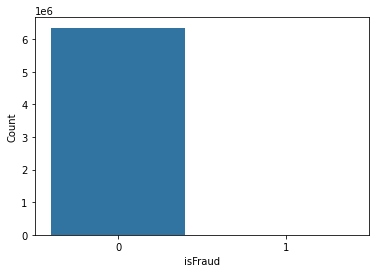

In [11]:
# count number of fraud and not fraud data
print(df.isFraud.value_counts())
sns.countplot(data=df, x='isFraud')
plt.ylabel('Count')
plt.show()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


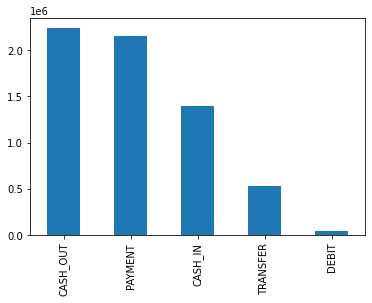

In [12]:
# Count number of data point in each type of transaction
print(df.type.value_counts())
df.type.value_counts().plot(kind='bar')
plt.show()

In [13]:
# Investigate variable "isFlaggedFraud"
pd.crosstab(df.isFraud, df.isFlaggedFraud)

isFlaggedFraud,0,1
isFraud,,
0,6354407,0
1,8197,16


In [14]:
# Groupby type
df.groupby('type')['isFraud', 'isFlaggedFraud'].sum()

<ipython-input-14-085e006cd28f>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('type')['isFraud','isFlaggedFraud'].sum()


,isFraud,isFlaggedFraud
type,,
CASH_IN,0,0
CASH_OUT,4116,0
DEBIT,0,0
PAYMENT,0,0
TRANSFER,4097,16


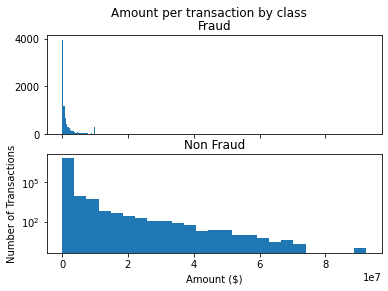

In [15]:
# Amount Vs number of transaction
fraud = df[df['isFraud'] == 1]
normal = df[df['isFraud'] == 0]
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 25
ax1.hist(fraud.amount, bins=bins)
ax1.set_title('Fraud')
ax2.hist(normal.amount, bins=bins)
ax2.set_title('Non Fraud')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
# plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

### Feature Engineering and Preprocessing

In [16]:
% % time
# Copy from Arjun Joshua
# Feature extraction
data = df.copy()

# Merchant flag for source and dist
data['OrigC'] = data['nameOrig'].apply(
    lambda x: 1 if str(x).find('C') == 0 else 0)
data['DestC'] = data['nameDest'].apply(
    lambda x: 1 if str(x).find('C') == 0 else 0)

# flag for transfer and cashout from type feature
data['TRANSFER'] = data['type'].apply(lambda x: 1 if x == 'TRANSFER' else 0)
data['CASH_OUT'] = data['type'].apply(lambda x: 1 if x == 'CASH_OUT' else 0)

Wall time: 8.21 s


In [17]:
# Calculating Amount error
data['OrigAmntErr'] = (abs(data.oldbalanceOrg-data.newbalanceOrig)-data.amount)

In [18]:
# drop list
# droping those feature which are id type category and those which used for feature extraction
droplist = ['isFlaggedFraud', 'type', 'nameDest', 'nameOrig']

In [19]:
# print result
def model_result(clf, x_test, y_test):
    y_prob = clf.predict_proba(x_test)
    y_pred = clf.predict(x_test)
    print('AUPRC :', (average_precision_score(y_test, y_prob[:, 1])))
    print('F1 - score :', (f1_score(y_test, y_pred)))
    print('Confusion_matrix : ')
    print(confusion_matrix(y_test, y_pred))
    print("accuracy_score")
    print(accuracy_score(y_test, y_pred))
    print("classification_report")
    print(classification_report(y_test, y_pred))

In [20]:
# droping feature which is in droplist
# Creating X and y for spliting dataset into test and train
MLData = data.drop(labels=droplist, axis=1)
X = MLData.drop('isFraud', axis=1)
Y = MLData.isFraud

In [25]:
# splinting data into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, shuffle=False)

In [28]:
# SMOTE oversampling
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

print(X_train.shape, y_train.shape)
print(X_train_over.shape, y_train_over.shape)

(4453834, 11) (4453834,)
(8900382, 11) (8900382,)


### ML Model

#### Random Forest

In [32]:
r_clf = RandomForestClassifier()
r_clf.fit(X_train, y_train)
print('Test (Oversampling X)')
model_result(r_clf, X_test, y_test)

Test (Oversampling X)
AUPRC : 0.9999997607077656
F1 - score : 0.9997811337272926
Confusion_matrix : 
[[1904216       0]
 [      2    4568]]
accuracy_score
0.9999989522136059
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1904216
           1       1.00      1.00      1.00      4570

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786



In [33]:
r_clf2 = RandomForestClassifier()
r_clf2.fit(X_train_over, y_train_over)
print('Test (Oversampling O)')
model_result(r_clf2, X_test, y_test)

Test (Oversampling O)
AUPRC : 0.9999993793063605
F1 - score : 0.9998905788379472
Confusion_matrix : 
[[1904216       0]
 [      1    4569]]
accuracy_score
0.999999476106803
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1904216
           1       1.00      1.00      1.00      4570

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786

